In [1]:
import numpy as np
import matplotlib.pyplot as plt
from flow_decomposition import FlowDecomposition
from flow_regression import FlowRegression, WeightedFlowRegression, DecomposedFlowRegression
from FastCCM import PairwiseCCM

Toy data preparation.

In [2]:


#############################################
# Test example using mixed Lorenz systems   #
#############################################

def simulate_lorenz(initial, sigma=10, rho=28, beta=8/3, dt=0.01, steps=1000):
    """
    Simulate a Lorenz attractor using Euler integration.
    Returns an array of shape (steps, 3).
    """
    trajectory = np.empty((steps, 3))
    trajectory[0] = initial
    for i in range(1, steps):
        x, y, z = trajectory[i-1]
        dx = sigma * (y - x)
        dy = x * (rho - z) - y
        dz = x * y - beta * z
        trajectory[i] = trajectory[i-1] + dt * np.array([dx, dy, dz])
    return trajectory

steps = 10000

# Simulate three independent Lorenz attractors.
traj1 = simulate_lorenz(initial=[1.0, 1.0, 1.0], steps=steps)
traj2 = simulate_lorenz(initial=[0.1, -1.0, 1.0], steps=steps)
traj3 = simulate_lorenz(initial=[0.5, 0.5, 0.0], steps=steps)

# Stack the three trajectories horizontally.
# This yields a latent data matrix of shape (steps, 9) [3 systems x 3 dimensions each].
X_latent = np.hstack([traj1, traj2, traj3])

M = np.random.randn(X_latent.shape[1], 20)  

# Mix the latent signals to generate the observed data.
X_mixed = X_latent @ M  # shape (steps, observed_dim)
X_mixed = (X_mixed - X_mixed.mean(axis=0))/X_mixed.std(axis=0)


`FlowDecomposition` usage example. Decomposition of mixed Lorenz dynamics.

In [ ]:

# Initialization parameters for FlowDecomposition.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "n_components": 3,        
    "num_delays": 0,
    "delay_step": 0,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.1,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range",
    "mask_size": None
}

fd = FlowDecomposition(**init_params)
fd.fit(X_mixed, **fit_params)

Epoch 1/500, Loss: 0.8722, ccm_loss: 0.8722, h_norm: 0.8416
Epoch 2/500, Loss: 0.9215, ccm_loss: 0.9215, h_norm: 0.8070
Epoch 3/500, Loss: 0.8171, ccm_loss: 0.8171, h_norm: 0.7989
Epoch 4/500, Loss: 0.8533, ccm_loss: 0.8533, h_norm: 0.8191
Epoch 5/500, Loss: 0.8321, ccm_loss: 0.8321, h_norm: 0.8030
Epoch 6/500, Loss: 0.8279, ccm_loss: 0.8279, h_norm: 0.7912
Epoch 7/500, Loss: 0.8461, ccm_loss: 0.8461, h_norm: 0.7965
Epoch 8/500, Loss: 0.7807, ccm_loss: 0.7807, h_norm: 0.7987
Epoch 9/500, Loss: 0.7601, ccm_loss: 0.7601, h_norm: 0.7946
Epoch 10/500, Loss: 0.7434, ccm_loss: 0.7434, h_norm: 0.7975
Epoch 11/500, Loss: 0.6612, ccm_loss: 0.6612, h_norm: 0.7936
Epoch 12/500, Loss: 0.5745, ccm_loss: 0.5745, h_norm: 0.8046
Epoch 13/500, Loss: 0.6034, ccm_loss: 0.6034, h_norm: 0.8011
Epoch 14/500, Loss: 0.4953, ccm_loss: 0.4953, h_norm: 0.8001
Epoch 15/500, Loss: 0.4762, ccm_loss: 0.4762, h_norm: 0.7940
Epoch 16/500, Loss: 0.5287, ccm_loss: 0.5287, h_norm: 0.8047
Epoch 17/500, Loss: 0.3981, ccm_l

In [4]:
unmixed = fd.transform(X_mixed)

In [5]:
fd.evaluate_loss(X_mixed, **fit_params)

0.13858070969581604

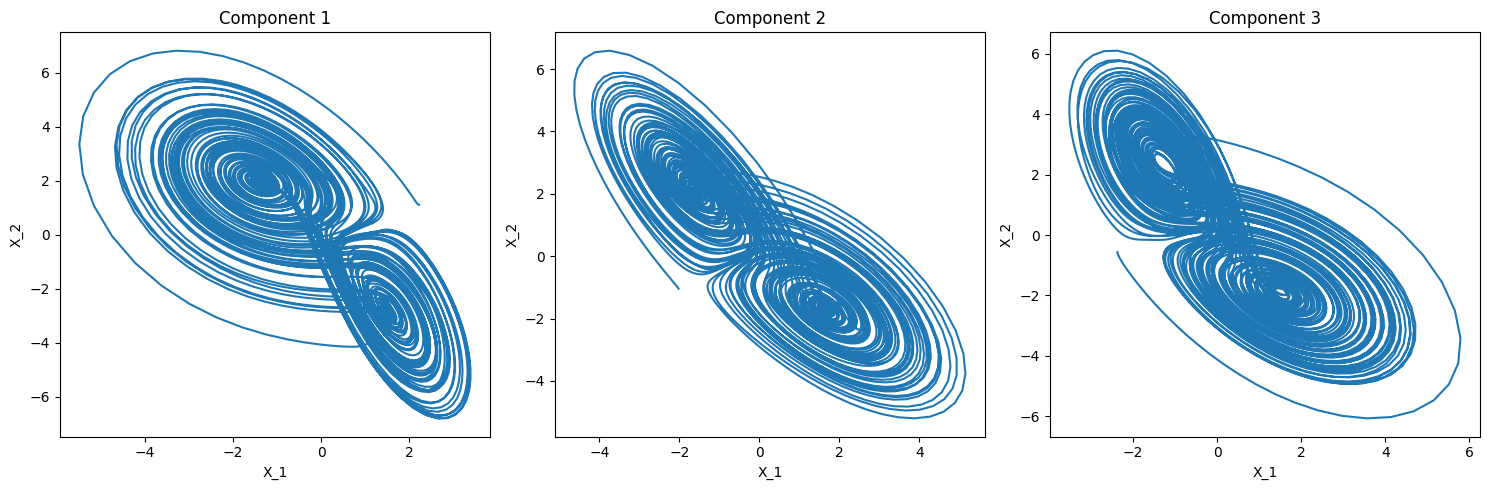

In [6]:

fig, axes = plt.subplots(nrows=1, ncols=unmixed.shape[1], figsize=(15, 5))
for i in range(unmixed.shape[1]):
    axes[i].plot(unmixed[:, i, 0], unmixed[:, i, 1])
    axes[i].set_title(f'Component {i+1}')
    axes[i].set_xlabel('X_1')
    axes[i].set_ylabel('X_2')
plt.tight_layout()
plt.show()

`FlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [12]:

# Initialization parameters for FlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = FlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, CCM Loss: 0.4450, h_norm: 0.8239, Total Loss: 0.4450
Epoch 2/500, CCM Loss: 0.3440, h_norm: 0.8187, Total Loss: 0.3440
Epoch 3/500, CCM Loss: 0.2820, h_norm: 0.8156, Total Loss: 0.2820
Epoch 4/500, CCM Loss: 0.2489, h_norm: 0.8127, Total Loss: 0.2489
Epoch 5/500, CCM Loss: 0.2111, h_norm: 0.8107, Total Loss: 0.2111
Epoch 6/500, CCM Loss: 0.1835, h_norm: 0.8091, Total Loss: 0.1835
Epoch 7/500, CCM Loss: 0.1677, h_norm: 0.8060, Total Loss: 0.1677
Epoch 8/500, CCM Loss: 0.1621, h_norm: 0.8027, Total Loss: 0.1621
Epoch 9/500, CCM Loss: 0.1506, h_norm: 0.8020, Total Loss: 0.1506
Epoch 10/500, CCM Loss: 0.1376, h_norm: 0.8009, Total Loss: 0.1376
Epoch 11/500, CCM Loss: 0.1352, h_norm: 0.7984, Total Loss: 0.1352
Epoch 12/500, CCM Loss: 0.1182, h_norm: 0.7967, Total Loss: 0.1182
Epoch 13/500, CCM Loss: 0.1133, h_norm: 0.7952, Total Loss: 0.1133
Epoch 14/500, CCM Loss: 0.1080, h_norm: 0.7947, Total Loss: 0.1080
Epoch 15/500, CCM Loss: 0.1017, h_norm: 0.7944, Total Loss: 0.1017
Epoc

In [8]:
unmixed = fd.transform(X_mixed)

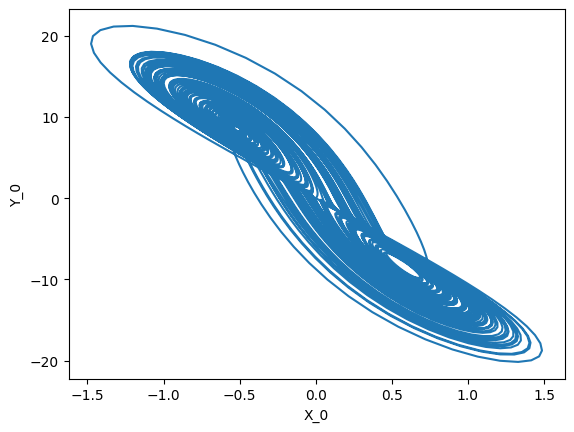

In [9]:
plt.plot(unmixed[:,0],y[:,0])
plt.xlabel('X_0')
plt.ylabel('Y_0')
plt.show()

`WeightedFlowRegression` usage example. Projecting mixed Lorenz dynamics onto the space where they cross-map to one of the original Lorenz systems.

In [14]:

# Initialization parameters for WeightedFlowRegression.
init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = traj1[:,:]

fd = WeightedFlowRegression(**init_params)
fd.fit(X=X_mixed, Y=y, **fit_params)

Epoch 1/500, CCM Loss: 0.4773, h_norm: 0.8411, Total Loss: -0.7395
Epoch 2/500, CCM Loss: 0.3738, h_norm: 0.8448, Total Loss: -0.9840
Epoch 3/500, CCM Loss: 0.3328, h_norm: 0.8555, Total Loss: -1.1001
Epoch 4/500, CCM Loss: 0.3010, h_norm: 0.8560, Total Loss: -1.2007
Epoch 5/500, CCM Loss: 0.2777, h_norm: 0.8543, Total Loss: -1.2811
Epoch 6/500, CCM Loss: 0.2595, h_norm: 0.8528, Total Loss: -1.3492
Epoch 7/500, CCM Loss: 0.2322, h_norm: 0.8524, Total Loss: -1.4602
Epoch 8/500, CCM Loss: 0.2225, h_norm: 0.8504, Total Loss: -1.5027
Epoch 9/500, CCM Loss: 0.2087, h_norm: 0.8479, Total Loss: -1.5667
Epoch 10/500, CCM Loss: 0.1992, h_norm: 0.8451, Total Loss: -1.6136
Epoch 11/500, CCM Loss: 0.1856, h_norm: 0.8407, Total Loss: -1.6842
Epoch 12/500, CCM Loss: 0.1689, h_norm: 0.8377, Total Loss: -1.7782
Epoch 13/500, CCM Loss: 0.1754, h_norm: 0.8353, Total Loss: -1.7409
Epoch 14/500, CCM Loss: 0.1549, h_norm: 0.8340, Total Loss: -1.8649
Epoch 15/500, CCM Loss: 0.1502, h_norm: 0.8327, Total Los

KeyboardInterrupt: 

In [4]:
unmixed = fd.transform(X_mixed)
weights = fd.predict_weights(X_mixed)

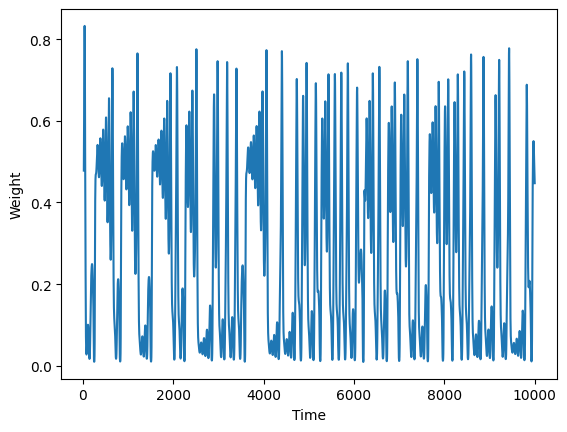

In [10]:
plt.plot(weights[:,0])
plt.xlabel('Time')
plt.ylabel('Weight')
plt.show()

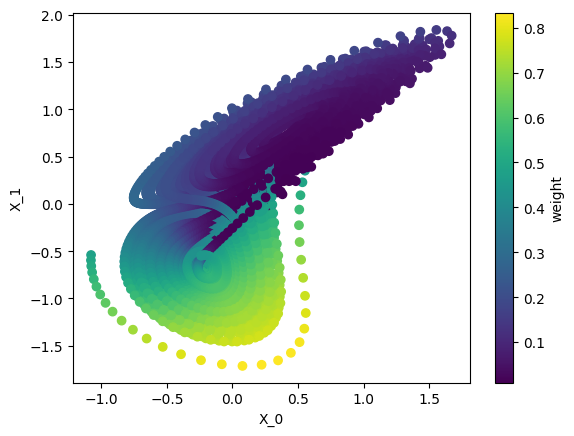

In [11]:
plt.scatter(unmixed[:,0],unmixed[:,1],c=weights[:,0])
plt.xlabel('X_0')
plt.ylabel('X_1')
plt.colorbar(label="weight")
plt.show()

In [9]:

init_params = {
    "input_dim": 20, 
    "proj_dim": 2,
    "n_components": 3,
    "num_delays": 3,
    "delay_step": 10,
    "model": "linear",
    "subtract_autocorr": False,
    "device": "cpu",
    "data_device": "cpu",
    "optimizer": "Adagrad",
    "learning_rate": 0.01,
    "random_state": None
}

# Fit parameters.
fit_params = {
    "sample_size": 150,
    "library_size": 1000,
    "exclusion_rad": 20,
    "time_intv": 80,
    "num_epochs": 500,
    "num_rand_samples": 32,
    "batch_size": 32,
    "method": "knn",
    "nbrs_num": 16,
    "theta": 5,
    "beta": 0,
    "optim_policy": "range"

}
y = X_mixed[:,[2]]

fd = DecomposedFlowRegression(**init_params)
fd.fit(X=X_mixed, Y=X_mixed, **fit_params)

Epoch 1/500, CCM Loss: 0.9930, h_norm: 0.8610, Total Loss: -0.0070
Epoch 2/500, CCM Loss: 0.9282, h_norm: 0.8656, Total Loss: -0.0745
Epoch 3/500, CCM Loss: 0.9108, h_norm: 0.8659, Total Loss: -0.0935
Epoch 4/500, CCM Loss: 0.8658, h_norm: 0.8694, Total Loss: -0.1440
Epoch 5/500, CCM Loss: 0.8501, h_norm: 0.8715, Total Loss: -0.1624
Epoch 6/500, CCM Loss: 0.8362, h_norm: 0.8700, Total Loss: -0.1789
Epoch 7/500, CCM Loss: 0.8246, h_norm: 0.8717, Total Loss: -0.1928
Epoch 8/500, CCM Loss: 0.8156, h_norm: 0.8697, Total Loss: -0.2038
Epoch 9/500, CCM Loss: 0.8033, h_norm: 0.8696, Total Loss: -0.2191
Epoch 10/500, CCM Loss: 0.8051, h_norm: 0.8681, Total Loss: -0.2168
Epoch 11/500, CCM Loss: 0.7830, h_norm: 0.8660, Total Loss: -0.2446
Epoch 12/500, CCM Loss: 0.7780, h_norm: 0.8656, Total Loss: -0.2511
Epoch 13/500, CCM Loss: 0.7386, h_norm: 0.8646, Total Loss: -0.3030
Epoch 14/500, CCM Loss: 0.7258, h_norm: 0.8636, Total Loss: -0.3205
Epoch 15/500, CCM Loss: 0.6763, h_norm: 0.8601, Total Los

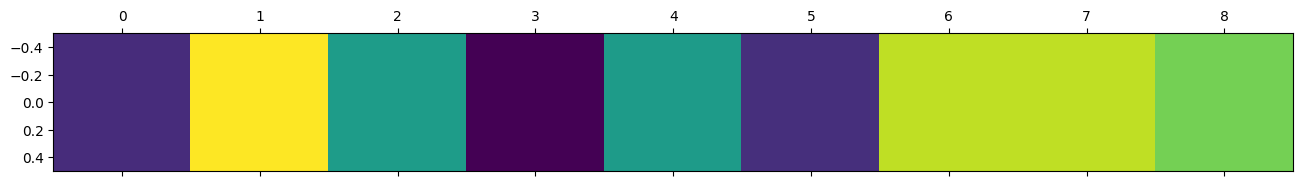

In [10]:
plt.matshow(np.abs(M[:,[2]]).T)

In [11]:
unmixed = fd.transform(X_mixed)

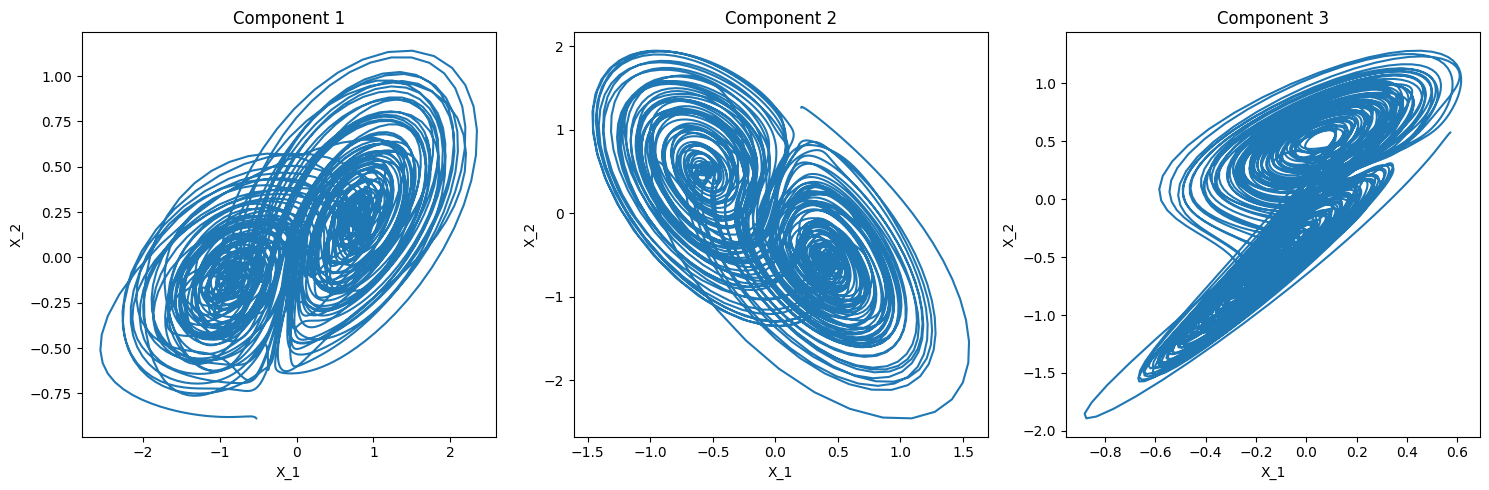

In [12]:

fig, axes = plt.subplots(nrows=1, ncols=unmixed.shape[1], figsize=(15, 5))
for i in range(unmixed.shape[1]):
    axes[i].plot(unmixed[:, i, 0], unmixed[:, i, 1])
    axes[i].set_title(f'Component {i+1}')
    axes[i].set_xlabel('X_1')
    axes[i].set_ylabel('X_2')
plt.tight_layout()
plt.show()

In [13]:
y.shape

(10000, 1)

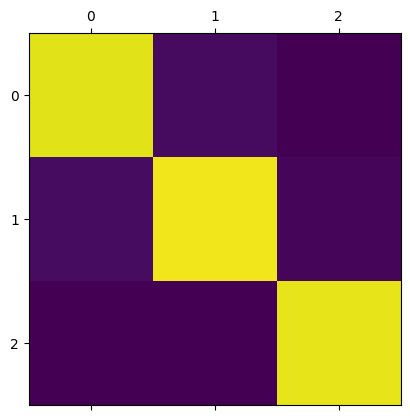

In [14]:
plt.matshow(PairwiseCCM("cpu").compute(unmixed.transpose(1,0,2),unmixed.transpose(1,0,2),3000,400,20,20).mean(axis=0),vmax=1,vmin=0)